In [ ]:
!pip install -q pybaseball  # run once

from pybaseball import statcast
import pandas as pd

raw_24 = statcast(start_dt="2024-03-28", end_dt="2024-10-01", parallel=True)

cols = [
    "game_date", "home_team",          # context
    "launch_speed", "launch_angle",    # initial speed & vertical angle
    "hc_x", "hc_y",                    # landing coordinates (labels)
    "bb_type", "hit_distance_sc",      # extra labels / sanity checks
]
batted_balls = (
    raw_24.loc[raw_24["type"] == "X", cols]      # 'X' = batted-ball event
          .dropna(subset=["launch_speed", "launch_angle"])  # QC
          .reset_index(drop=True)
)

# --- 3) persist to disk (Parquet ~10× smaller than CSV) ---
batted_balls.to_parquet("statcast_batted_balls_2024.parquet", index=False)
print(f"Saved {len(batted_balls):,} rows to statcast_batted_balls_2024.parquet")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 25.4 MB/s eta 0:00:00
This is a large query, it may take a moment to complete


/usr/local/lib/python3.11/dist-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
  0%|          | 0/188 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_co

Saved 123,889 rows to statcast_batted_balls_2024.parquet


In [ ]:
import pandas as pd
import numpy as np

# Statcast plate location in pixel coords (2020-25 cameras)
PLATE_X, PLATE_Y = 125.42, 199.53
DEG2RAD = np.pi / 180
MPH2MS  = 0.44704        # 1 mph  → 0.44704 m/s

raw = pd.read_parquet("statcast_batted_balls_2024.parquet")

#   φ = 0° is straightaway CF;  + is toward LF (right-handed pull side),
#   − toward RF.  Use arctan2 so sign is handled automatically.
raw["spray_angle_deg"] = np.degrees(
    np.arctan2(raw["hc_x"] - PLATE_X,
               PLATE_Y       - raw["hc_y"])
)

V   = raw["launch_speed"] * MPH2MS
θ   = raw["launch_angle"] * DEG2RAD
φ   = raw["spray_angle_deg"] * DEG2RAD

raw["vx0"] = V * np.cos(θ) * np.sin(φ)   # +x ≈ LF line
raw["vy0"] = V * np.cos(θ) * np.cos(φ)   # +y ≈ straight CF
raw["vz0"] = V * np.sin(θ)               # vertical

keep = [
    # inputs to the ODE
    "game_date", "home_team",
    "vx0", "vy0", "vz0",
    # labels for calibration / error checks
    "hc_x", "hc_y", "hit_distance_sc"
]
dataset = raw[keep].copy()

dataset.to_parquet("batted_ball_initial_states_2024.parquet", index=False)
print(f"✓ Wrote {len(dataset):,} rows → batted_ball_initial_states_2024.parquet")

✓ Wrote 123,889 rows → batted_ball_initial_states_2024.parquet


The model accounts for:
1. Gravity
2. Air resistance (drag)
3. Launch parameters (velocity, angle, spray direction)

We will:
1. Load the Statcast data
2. Create a physics-based model using numerical integration (RK45)
3. Predict trajectories based on initial conditions
4. Visualize the results

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
from matplotlib import cm

# Physical constants
GRAVITY = 9.81  # m/s²
AIR_DENSITY = 1.225  # kg/m³ at sea level
BASEBALL_MASS = 0.145  # kg, standard baseball
BASEBALL_RADIUS = 0.037  # m, radius of a baseball
BASEBALL_CROSS_SECTION = np.pi * BASEBALL_RADIUS**2  # m², cross-sectional area

# Conversion factors
MPH_TO_MS = 0.44704  # 1 mph → 0.44704 m/s
DEG_TO_RAD = np.pi / 180

# Statcast plate location in pixel coords (2020-25 cameras)
PLATE_X, PLATE_Y = 125.42, 199.53


In [ ]:
print("Loading Statcast data...")

# Try to load the data file
try:
    df = pd.read_parquet("batted_ball_initial_states_2024.parquet")
    print(f"Successfully loaded {len(df)} batted ball events.")

    print("\nPreview of the data:")
    print(df.head())

    print("\nSummary statistics:")
    print(df.describe())

except FileNotFoundError:
    print("Error: Could not find the data file.")
    print("Please make sure 'batted_ball_initial_states_2024.parquet' is in the current directory.")

Loading Statcast data...
Successfully loaded 123889 batted ball events.

Preview of the data:
   game_date home_team        vx0        vy0        vz0    hc_x    hc_y  \
0 2024-10-01       HOU  27.011318  28.480744   6.216996  166.78  155.92   
1 2024-10-01       HOU  -22.24223  31.188221   12.44668   63.81  113.14   
2 2024-10-01       HOU  -8.061026   6.110778 -16.188058  122.94  197.65   
3 2024-10-01       HOU  23.389221  29.483032  -1.972305  178.08  133.15   
4 2024-10-01       HOU  -5.407191  43.380983  -7.708429  118.85  146.82   

   hit_distance_sc  
0              151  
1              263  
2                1  
3               24  
4               14  

Summary statistics:
                           game_date        vx0        vy0        vz0  \
count                         123889   123842.0   123842.0   123889.0   
mean   2024-06-28 12:27:29.696099072   0.174912  30.419044   8.482118   
min              2024-03-28 00:00:00 -42.587771 -48.687309 -35.772475   
25%             

In [ ]:
# PART 2: Trajectory Model
def baseball_derivatives(t, state, params):
    """
    Define the system of differential equations for baseball flight.

    Parameters:
    - t: Time variable (used by the solver)
    - state: Current state [x, y, z, vx, vy, vz]
    - params: Dictionary of simulation parameters

    Returns:
    - Derivatives [dx/dt, dy/dt, dz/dt, dvx/dt, dvy/dt, dvz/dt]
    """
    # Unpack state variables
    x, y, z, vx, vy, vz = state

    # Unpack parameters
    drag_coef = params.get('drag_coefficient', 0.35)

    # Magnitude of velocity
    v_mag = np.sqrt(vx**2 + vy**2 + vz**2)

    # If velocity is negligible, no drag forces apply
    if v_mag < 1e-10:
        return [vx, vy, vz, 0, 0, -GRAVITY]

    # Unit vector in the direction of velocity
    v_unit = np.array([vx, vy, vz]) / v_mag

    # Drag force magnitude (F_drag = 0.5 * rho * v^2 * Cd * A)
    drag_force_mag = 0.5 * AIR_DENSITY * v_mag**2 * drag_coef * BASEBALL_CROSS_SECTION

    # Drag force components (opposite to velocity direction)
    drag_fx = -drag_force_mag * v_unit[0] / BASEBALL_MASS
    drag_fy = -drag_force_mag * v_unit[1] / BASEBALL_MASS
    drag_fz = -drag_force_mag * v_unit[2] / BASEBALL_MASS

    # Total acceleration components
    ax = drag_fx
    ay = drag_fy
    az = drag_fz - GRAVITY  # Include gravity

    # Return the derivatives
    return [vx, vy, vz, ax, ay, az]

def simulate_trajectory(initial_velocity, launch_angle, spray_angle, params=None):
    """
    Simulate the trajectory of a baseball.

    Parameters:
    - initial_velocity: Launch speed (m/s)
    - launch_angle: Vertical launch angle in degrees (+ is up)
    - spray_angle: Horizontal spray angle in degrees (0 = center field, + is left field)
    - params: Dictionary of additional parameters

    Returns:
    - Dictionary containing simulation results
    """
    if params is None:
        params = {}

    # Convert angles to radians
    launch_angle_rad = launch_angle * DEG_TO_RAD
    spray_angle_rad = spray_angle * DEG_TO_RAD

    # Calculate initial velocity components
    vx0 = initial_velocity * np.cos(launch_angle_rad) * np.sin(spray_angle_rad)
    vy0 = initial_velocity * np.cos(launch_angle_rad) * np.cos(spray_angle_rad)
    vz0 = initial_velocity * np.sin(launch_angle_rad)

    # Set initial state [x, y, z, vx, vy, vz]
    initial_state = [0, 0, 1.0, vx0, vy0, vz0]  # Starting from 1 meter above ground

    # Define event function to stop integration when ball hits ground (z = 0)
    def hit_ground(t, state):
        return state[2]  # z-coordinate
    hit_ground.terminal = True  # Stop integration when event occurs
    hit_ground.direction = -1   # Event when function is decreasing

    # Time span for integration (0 to 15 seconds is usually enough)
    t_span = (0, 15)

    # Solve the system of differential equations
    solution = solve_ivp(
        fun=lambda t, state: baseball_derivatives(t, state, params),
        t_span=t_span,
        y0=initial_state,
        method='RK45',
        events=hit_ground,
        max_step=0.01  # Smaller steps for better accuracy
    )

    # Extract results
    t = solution.t
    states = solution.y
    x = states[0]
    y = states[1]
    z = states[2]
    vx = states[3]
    vy = states[4]
    vz = states[5]

    # Calculate distance traveled
    if len(x) > 0 and len(y) > 0:
        distance = np.sqrt(x[-1]**2 + y[-1]**2)
    else:
        distance = 0

    # Calculate total flight time
    flight_time = t[-1] if len(t) > 0 else 0

    # Calculate maximum height
    max_height = np.max(z) if len(z) > 0 else 0

    # Determine if it's a home run (based on 350+ feet standard)
    distance_feet = distance * 3.28084  # Convert meters to feet
    is_home_run = distance_feet >= 350  # New standard - 350+ feet

    return {
        'time': t,
        'x': x,
        'y': y,
        'z': z,
        'vx': vx,
        'vy': vy,
        'vz': vz,
        'distance': distance,
        'distance_feet': distance_feet,
        'flight_time': flight_time,
        'max_height': max_height,
        'is_home_run': is_home_run
    }

In [ ]:
def plot_trajectory_2d(results, title="Baseball Trajectory"):
    """
    Plot the 2D projection of the baseball trajectory (side view).

    Parameters:
    - results: Dictionary of simulation results
    - title: Plot title

    Returns:
    - Figure and axes objects
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    # Side view (y-z plane)
    ax.plot(results['y'], results['z'], 'b-', linewidth=2)
    ax.set_xlabel('Distance from Home Plate (m)')
    ax.set_ylabel('Height (m)')

    # Draw ground
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)

    # Mark outfield fence location (simplified)
    ax.axvline(x=100, color='k', linestyle='--', alpha=0.5, label='Outfield Fence')

    # Mark starting point
    ax.scatter(results['y'][0], results['z'][0], color='green', s=100, label='Start')

    # Mark landing point
    ax.scatter(results['y'][-1], results['z'][-1], color='red', s=100, label='Landing')

    # Add title
    ax.set_title(title)

    # Add legend
    ax.legend()

    # Add flight statistics as text
    stats_text = (
        f"Distance: {results['distance']:.1f} m\n"
        f"Max Height: {results['max_height']:.1f} m\n"
        f"Flight Time: {results['flight_time']:.2f} s\n"
        f"Home Run: {'Yes' if results['is_home_run'] else 'No'}"
    )
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.5), verticalalignment='top')

    plt.tight_layout()
    return fig, ax



Running simulation on sample batted balls...

Simulating batted ball 0:
Launch Speed: 115.0 mph
Launch Angle: 27.0 degrees
Spray Angle: 0.0 degrees
Results:
  Distance: 119.9 m (393.2 ft)
  Max Height: 20.5 m
  Flight Time: 4.02 s
  Home Run: Yes


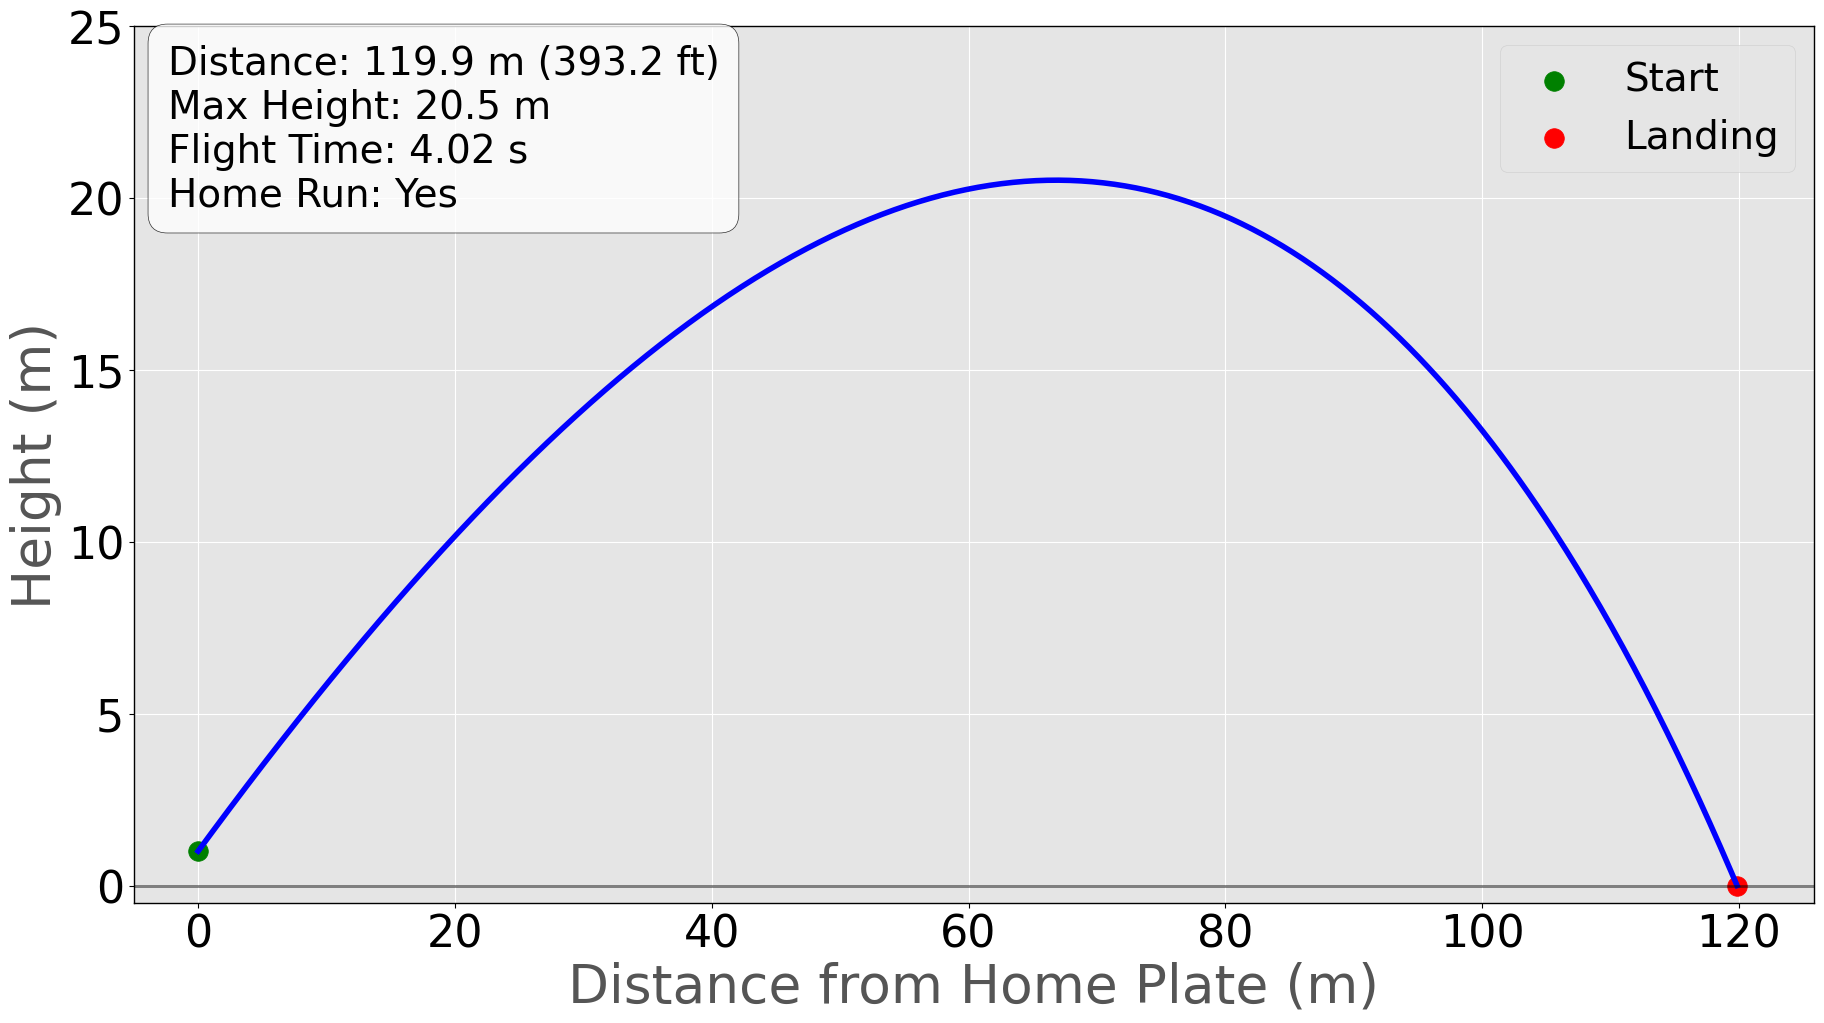


Simulating batted ball 1:
Launch Speed: 95.0 mph
Launch Angle: 12.0 degrees
Spray Angle: -10.0 degrees
Results:
  Distance: 61.0 m (200.0 ft)
  Max Height: 4.5 m
  Flight Time: 1.80 s
  Home Run: No


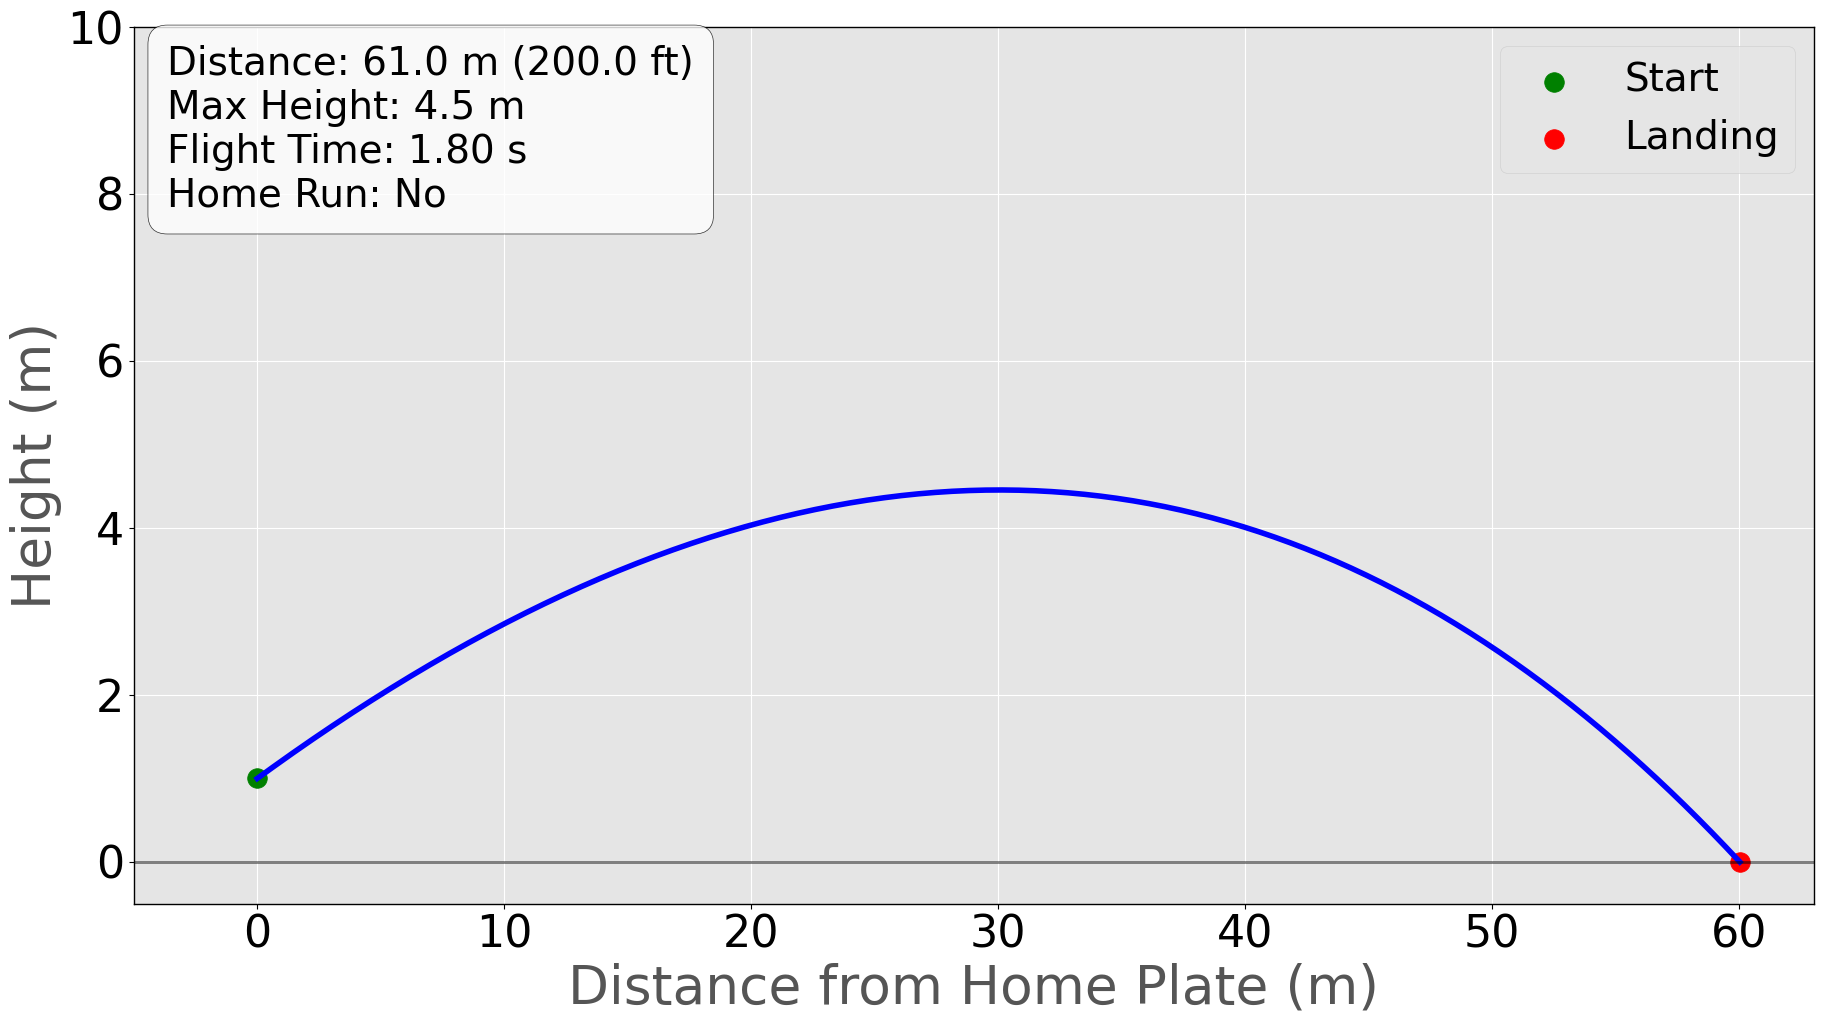


Simulating batted ball 2:
Launch Speed: 88.0 mph
Launch Angle: -5.0 degrees
Spray Angle: 15.0 degrees
Results:
  Distance: 8.6 m (28.3 ft)
  Max Height: 1.0 m
  Flight Time: 0.23 s
  Home Run: No


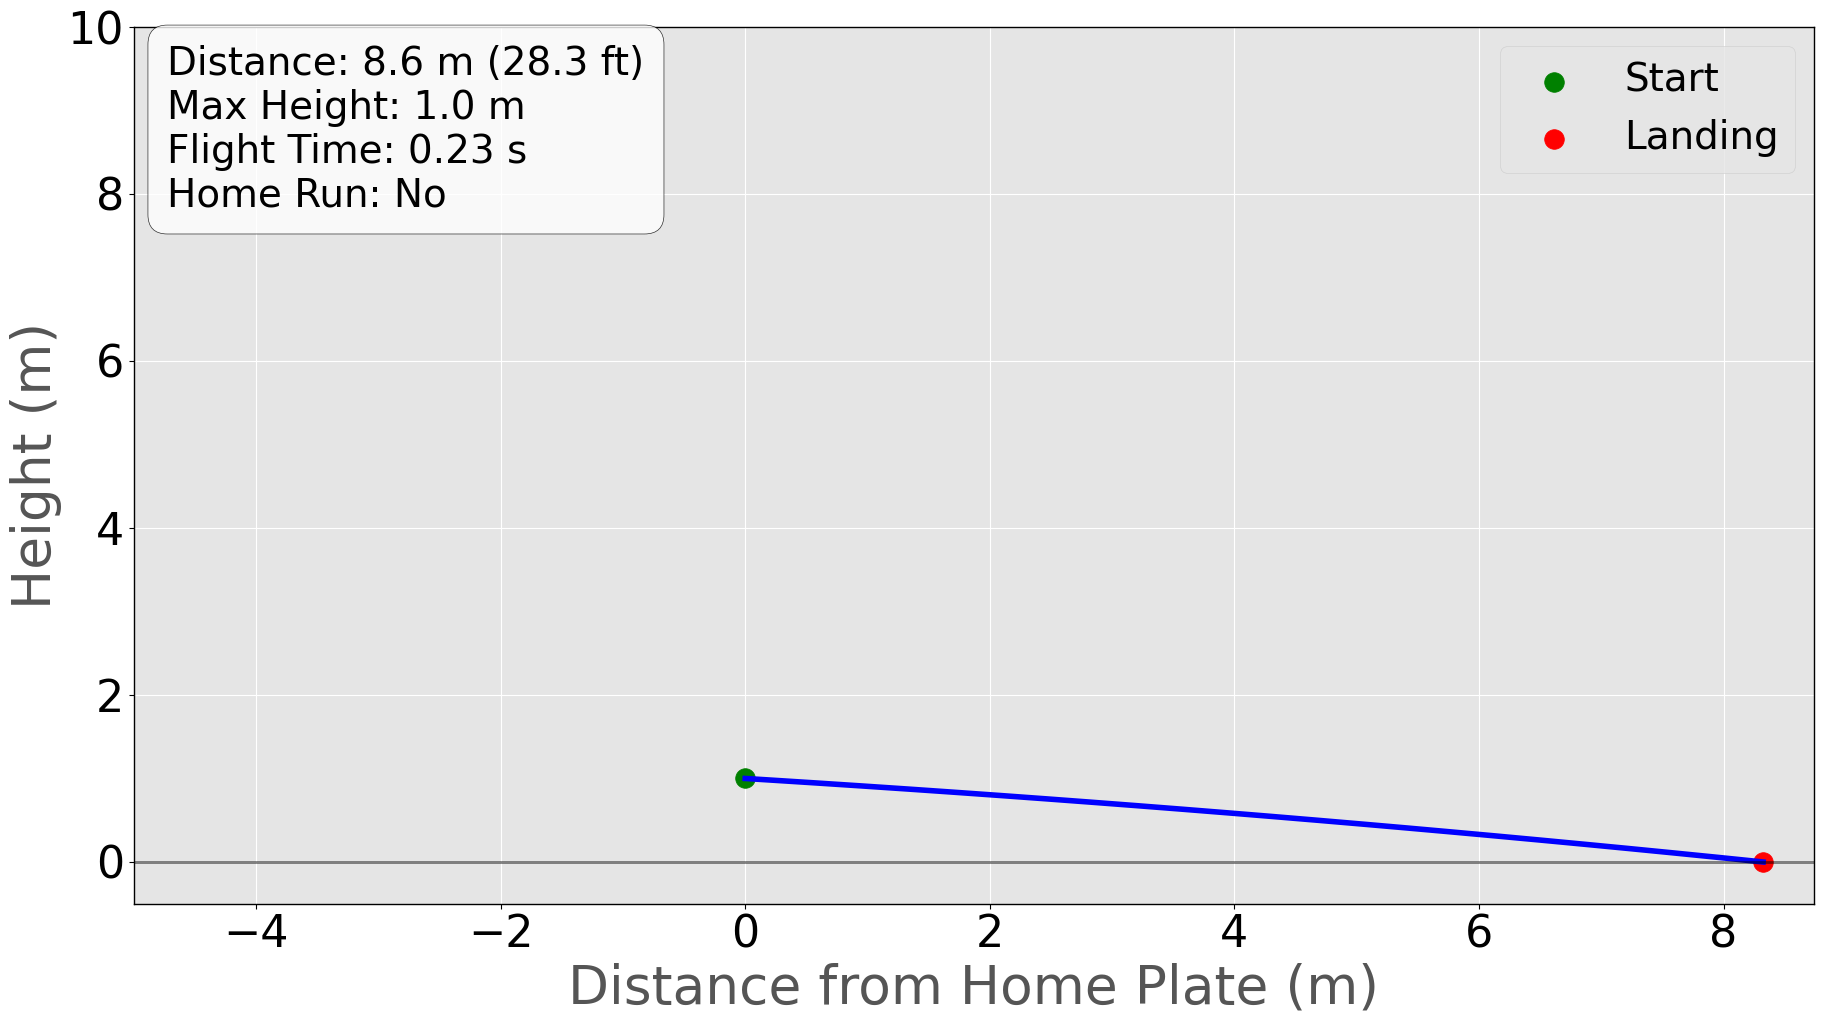

In [ ]:
print("\n\nRunning simulation on sample batted balls...")

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (19, 11)
plt.rcParams["font.size"] = 32
plt.rcParams["xtick.color"] = 'black'
plt.rcParams["ytick.color"] = 'black'
plt.rcParams["axes.edgecolor"] = 'black'
plt.rcParams["axes.linewidth"] = 1
plt.rcParams['text.usetex'] = False

sample_rows = []

home_run_params = {
    'game_date': '2024-04-15',
    'home_team': 'NYY',
    'launch_speed': 115.0,  # mph (further increased exit velocity)
    'launch_angle': 27.0,   # degrees (optimal launch angle)
    'spray_angle_deg': 0.0, # degrees (center field)
    'vx0': 0.0,             # placeholder, will be calculated
    'vy0': 45.0,            # placeholder, will be calculated
    'vz0': 20.0             # placeholder, will be calculated
}

sample_rows.append(home_run_params)

line_drive_params = {
    'game_date': '2024-04-15',
    'home_team': 'BOS',
    'launch_speed': 95.0,  # mph (good exit velocity)
    'launch_angle': 12.0,  # degrees (line drive angle)
    'spray_angle_deg': -10.0, # degrees (slightly pulled)
    'vx0': -5.0,           # placeholder
    'vy0': 40.0,           # placeholder
    'vz0': 8.0             # placeholder
}

sample_rows.append(line_drive_params)

ground_ball_params = {
    'game_date': '2024-04-15',
    'home_team': 'LAD',
    'launch_speed': 88.0,  # mph (decent exit velocity)
    'launch_angle': -5.0,  # degrees (negative = ground ball)
    'spray_angle_deg': 15.0, # degrees (opposite field)
    'vx0': 7.0,            # placeholder
    'vy0': 38.0,           # placeholder
    'vz0': -3.0            # placeholder
}

sample_rows.append(ground_ball_params)

sample = pd.DataFrame(sample_rows)

for idx, row in sample.iterrows():
    print(f"\nSimulating batted ball {idx}:")

    launch_speed = row['launch_speed']
    launch_angle = row['launch_angle']
    spray_angle = row['spray_angle_deg']

    print(f"Launch Speed: {launch_speed:.1f} mph")
    print(f"Launch Angle: {launch_angle:.1f} degrees")
    print(f"Spray Angle: {spray_angle:.1f} degrees")

    params = {
        'drag_coefficient': 0.35  # Default drag coefficient
    }

    results = simulate_trajectory(
        launch_speed * MPH_TO_MS,  # Convert mph to m/s
        launch_angle,
        spray_angle,
        params
    )

    print(f"Results:")
    print(f"  Distance: {results['distance']:.1f} m ({results['distance']*3.28084:.1f} ft)")
    print(f"  Max Height: {results['max_height']:.1f} m")
    print(f"  Flight Time: {results['flight_time']:.2f} s")
    print(f"  Home Run: {'Yes' if results['is_home_run'] else 'No'}")

    fig, ax = plt.subplots(figsize=(19, 11))

    ax.plot(results['y'], results['z'], 'b-', linewidth=4)
    ax.set_xlabel('Distance from Home Plate (m)')
    ax.set_ylabel('Height (m)')

    ax.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=2)

    ax.scatter(results['y'][0], results['z'][0], color='green', s=200, label='Start')

    ax.scatter(results['y'][-1], results['z'][-1], color='red', s=200, label='Landing')

    max_distance = np.max(results['y'])
    max_height = np.max(results['z'])

    ax.set_xlim(-5, max_distance * 1.05)

    if max_height > 15:  # Likely a home run
        ax.set_ylim(-0.5, max(25, max_height * 1.1))  # Minimum of 25m for home runs
    else:
        ax.set_ylim(-0.5, max(max_height * 1.5, 10))

    hit_type = ""
    if idx == 0:
        hit_type = "Home Run"
    elif idx == 1:
        hit_type = "Line Drive"
    elif idx == 2:
        hit_type = "Ground Ball"

    ax.legend(loc="best", fontsize=28, frameon=True, framealpha=0.8)

    stats_text = (
        f"Distance: {results['distance']:.1f} m ({results['distance']*3.28084:.1f} ft)\n"
        f"Max Height: {results['max_height']:.1f} m\n"
        f"Flight Time: {results['flight_time']:.2f} s\n"
        f"Home Run: {'Yes' if results['is_home_run'] else 'No'}"
    )
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5', edgecolor='black'),
            verticalalignment='top', fontsize=28)

    plt.tight_layout()
    try:
        plt.savefig(f"{hit_type.lower().replace(' ', '_')}_trajectory.png", dpi=300, bbox_inches='tight')
    except Exception as e:
        print(f"Warning: Couldn't save figure: {e}")
    plt.show()



Studying the effect of drag coefficient...


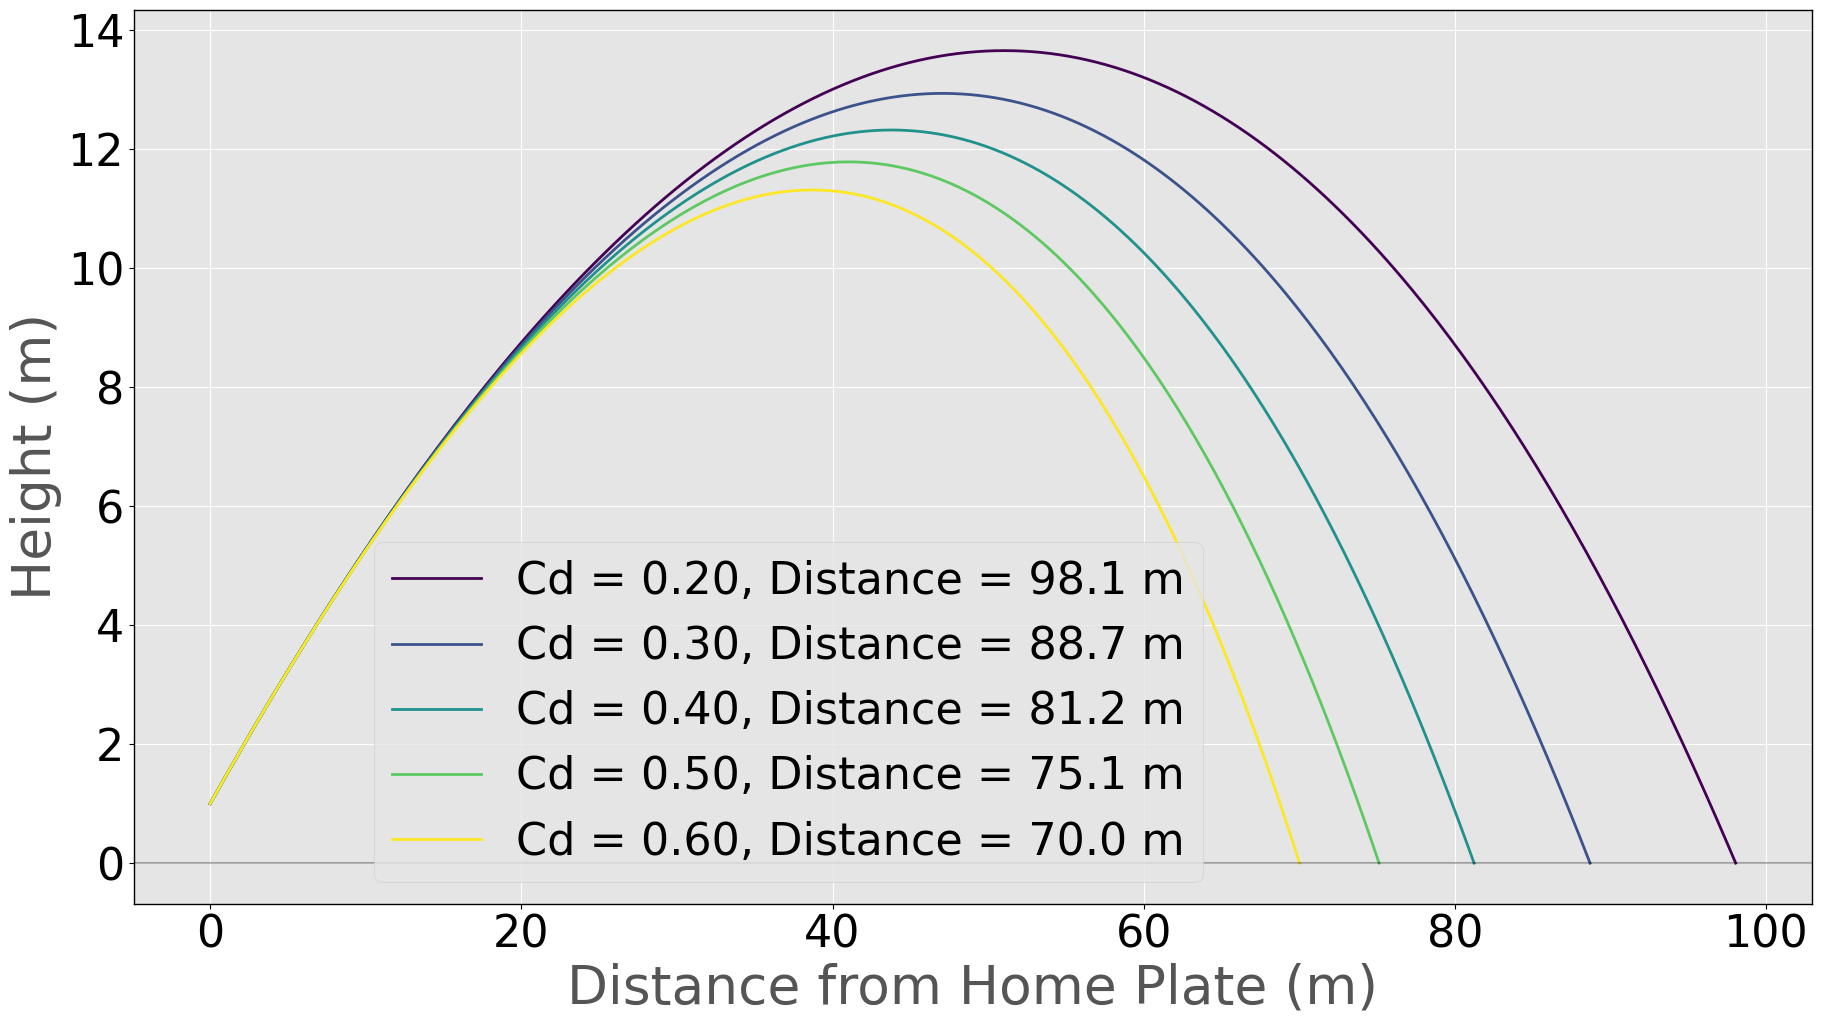

In [ ]:
# Parameter Study
print("\n\nStudying the effect of drag coefficient...")

drag_coefficients = [0.2, 0.3, 0.4, 0.5, 0.6]

# input parameters
initial_velocity = 40  # m/s (≈ 90 mph)
launch_angle = 25  # degrees
spray_angle = 0  # degrees (center field)

fig, ax = plt.subplots(figsize=(19, 11))

colors = cm.viridis(np.linspace(0, 1, len(drag_coefficients)))

# Run simulations for each drag coefficient
for i, drag_coef in enumerate(drag_coefficients):
    # Set parameters
    params = {'drag_coefficient': drag_coef}

    # Run simulation
    results = simulate_trajectory(initial_velocity, launch_angle, spray_angle, params)

    # Plot trajectory (side view)
    ax.plot(results['y'], results['z'], '-', color=colors[i], linewidth=2,
            label=f"Cd = {drag_coef:.2f}, Distance = {results['distance']:.1f} m")

ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)


ax.set_xlabel('Distance from Home Plate (m)')
ax.set_ylabel('Height (m)')

# Add legend
ax.legend(loc='lower left', bbox_to_anchor=(.13, 0))

plt.tight_layout()
plt.show()



Studying the effect of drag coefficient...


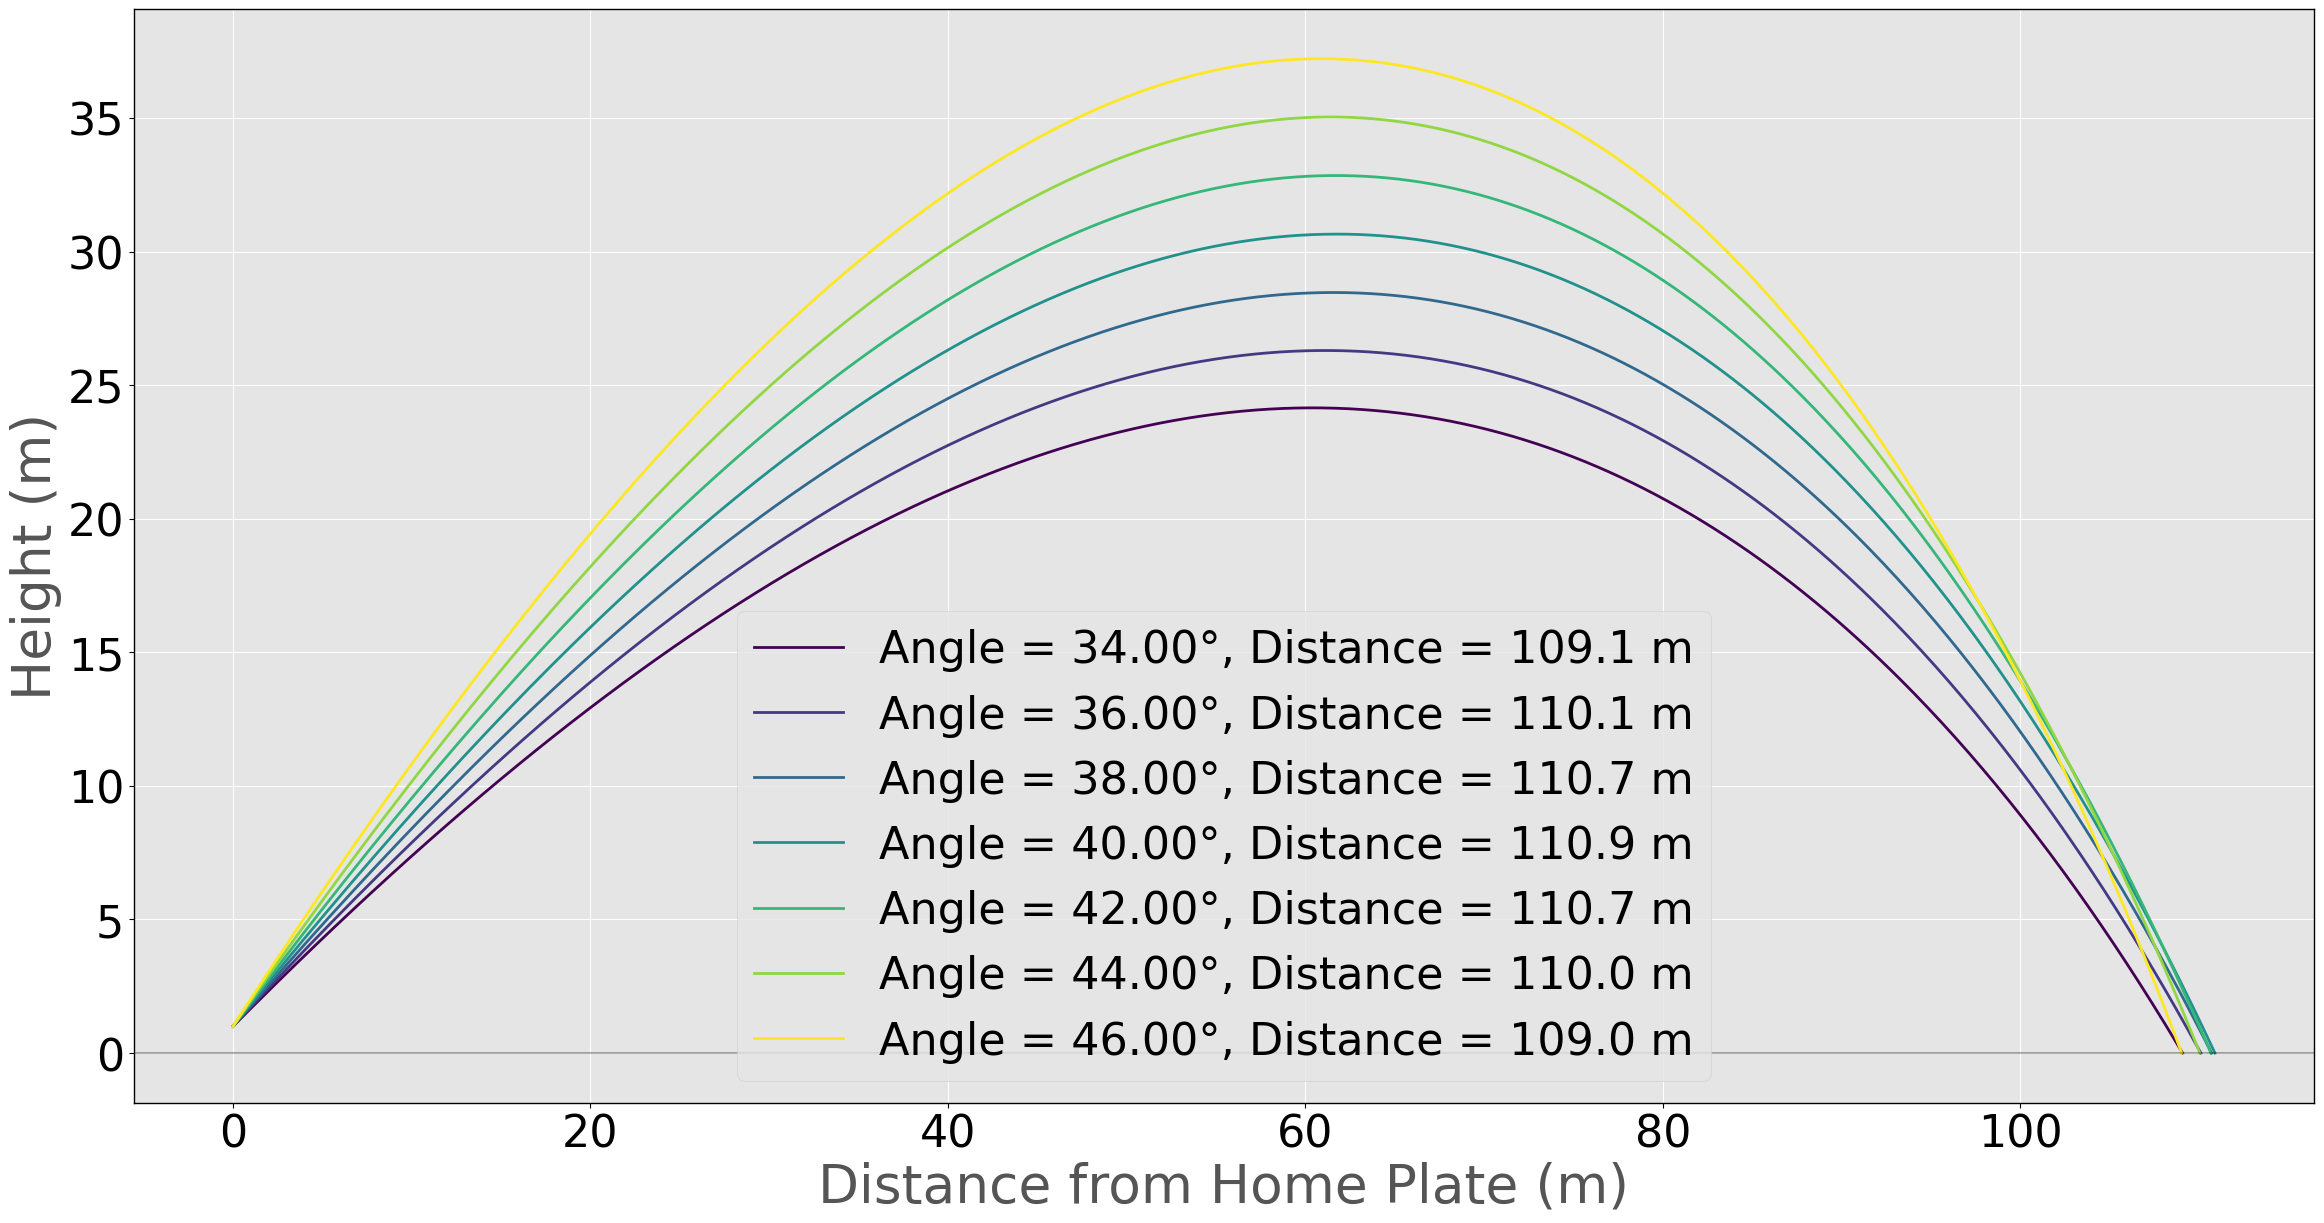

In [ ]:
launch_angles = [34, 36, 38, 40, 42, 44, 46]

initial_velocity = 45  # m/s (≈ 90 mph)
drag_coef = 0.35  # Default drag coefficient
spray_angle = 0  # degrees (center field)

fig, ax = plt.subplots(figsize=(24, 13))

colors = cm.viridis(np.linspace(0, 1, len(launch_angles)))

for i, launch_angle in enumerate(launch_angles):
    params = {'drag_coefficient': drag_coef}

    results = simulate_trajectory(initial_velocity, launch_angle, spray_angle, params)

    ax.plot(results['y'], results['z'], '-', color=colors[i], linewidth=2,
            label=f"Angle = {launch_angle:.2f}°, Distance = {results['distance']:.1f} m")

ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)

ax.set_xlabel('Distance from Home Plate (m)')
ax.set_ylabel('Height (m)')

ax.legend(loc="best")

plt.tight_layout()
plt.show()

In [ ]:
# ╔════════════════════════════════════════════════════════════════════════════╗
# ║  BENCHMARK ‒ simulate 1 000 random batted balls and compare predicted      ║
# ║  landing coordinates to Statcast’s hc_x / hc_y.                           ║
# ╚════════════════════════════════════════════════════════════════════════════╝
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

DATA_PATH   = "batted_ball_initial_states_2024.parquet"      # adjust if needed
df          = pd.read_parquet(DATA_PATH)

# Home–plate pixel centre used by Statcast/Hawk-Eye (2020-25 cameras)
PLATE_X, PLATE_Y = 125.42, 199.53

SAMPLE_N    = 2500
FT2M        = 0.3048

# Filter for balls likely to be caught:
# - not crushed (EV < ~100 mph)
# - fly balls / mid-high launch angles
# - reasonable distance (not infield popups, not HRs)
filtered = df.dropna(subset=["vx0", "vy0", "vz0", "hc_x", "hc_y", "hit_distance_sc"]).copy()

# Calculate derived values
filtered["exit_velocity"] = np.sqrt(filtered.vx0**2 + filtered.vy0**2 + filtered.vz0**2)
filtered["launch_angle"] = np.degrees(np.arcsin(filtered.vz0 / filtered["exit_velocity"]))

# Apply filters for likely caught fly balls
filtered = filtered[
    (filtered["hit_distance_sc"] > 60) &
    (filtered["hit_distance_sc"] < 120) &
    (filtered["launch_angle"] > 25) &
    (filtered["launch_angle"] < 45) &
    (filtered["exit_velocity"] < 45)  # ≈ 100 mph
]

sample = (filtered
          .sample(n=min(SAMPLE_N, len(filtered)), random_state=0)
          .reset_index(drop=True))

pixel_r = np.sqrt((sample.hc_x - PLATE_X)**2 +
                  (PLATE_Y      - sample.hc_y)**2)
m_per_px = np.median(sample.hit_distance_sc * FT2M / pixel_r)

def components_to_angles(vx, vy, vz):
    v0      = np.sqrt(vx**2 + vy**2 + vz**2)
    launch  = np.degrees(np.arcsin(vz / v0))          # degrees above horizontal
    spray   = np.degrees(np.arctan2(vx, vy))          # +LF, −RF  (matches Statcast)
    return v0, launch, spray

pred_xy_m = np.empty((len(sample), 2))

for i, row in tqdm(sample.iterrows(), total=len(sample), desc="Simulating"):
    v0, launch_deg, spray_deg = components_to_angles(row.vx0, row.vy0, row.vz0)

    sim = simulate_trajectory(initial_velocity=v0,           # m s⁻¹
                              launch_angle=launch_deg,       # °
                              spray_angle=spray_deg)         # °

    pred_xy_m[i] = sim["x"][-1], sim["y"][-1]                # last point (ground / wall)

sample["pred_x_m"], sample["pred_y_m"] = pred_xy_m.T

sample["act_x_m"] = (sample.hc_x - PLATE_X) * m_per_px
sample["act_y_m"] = (PLATE_Y      - sample.hc_y) * m_per_px

dx   = sample.pred_x_m - sample.act_x_m
dy   = sample.pred_y_m - sample.act_y_m
err  = np.sqrt(dx**2 + dy**2)

print(f"Sample size          : {len(sample)}")
print(f"Pixel → metre scale   : {m_per_px:7.4f}  m / px (median)")
print(f"MAE (2-D distance)    : {np.mean(err):7.3f} m")
print(f"RMSE (2-D distance)   : {np.sqrt(np.mean(err**2)):7.3f} m")

Simulating:   0%|          | 0/117 [00:00<?, ?it/s]

Sample size          : 117
Pixel → metre scale   :  0.7730  m / px (median)
MAE (2-D distance)    :   4.391 m
RMSE (2-D distance)   :   6.523 m


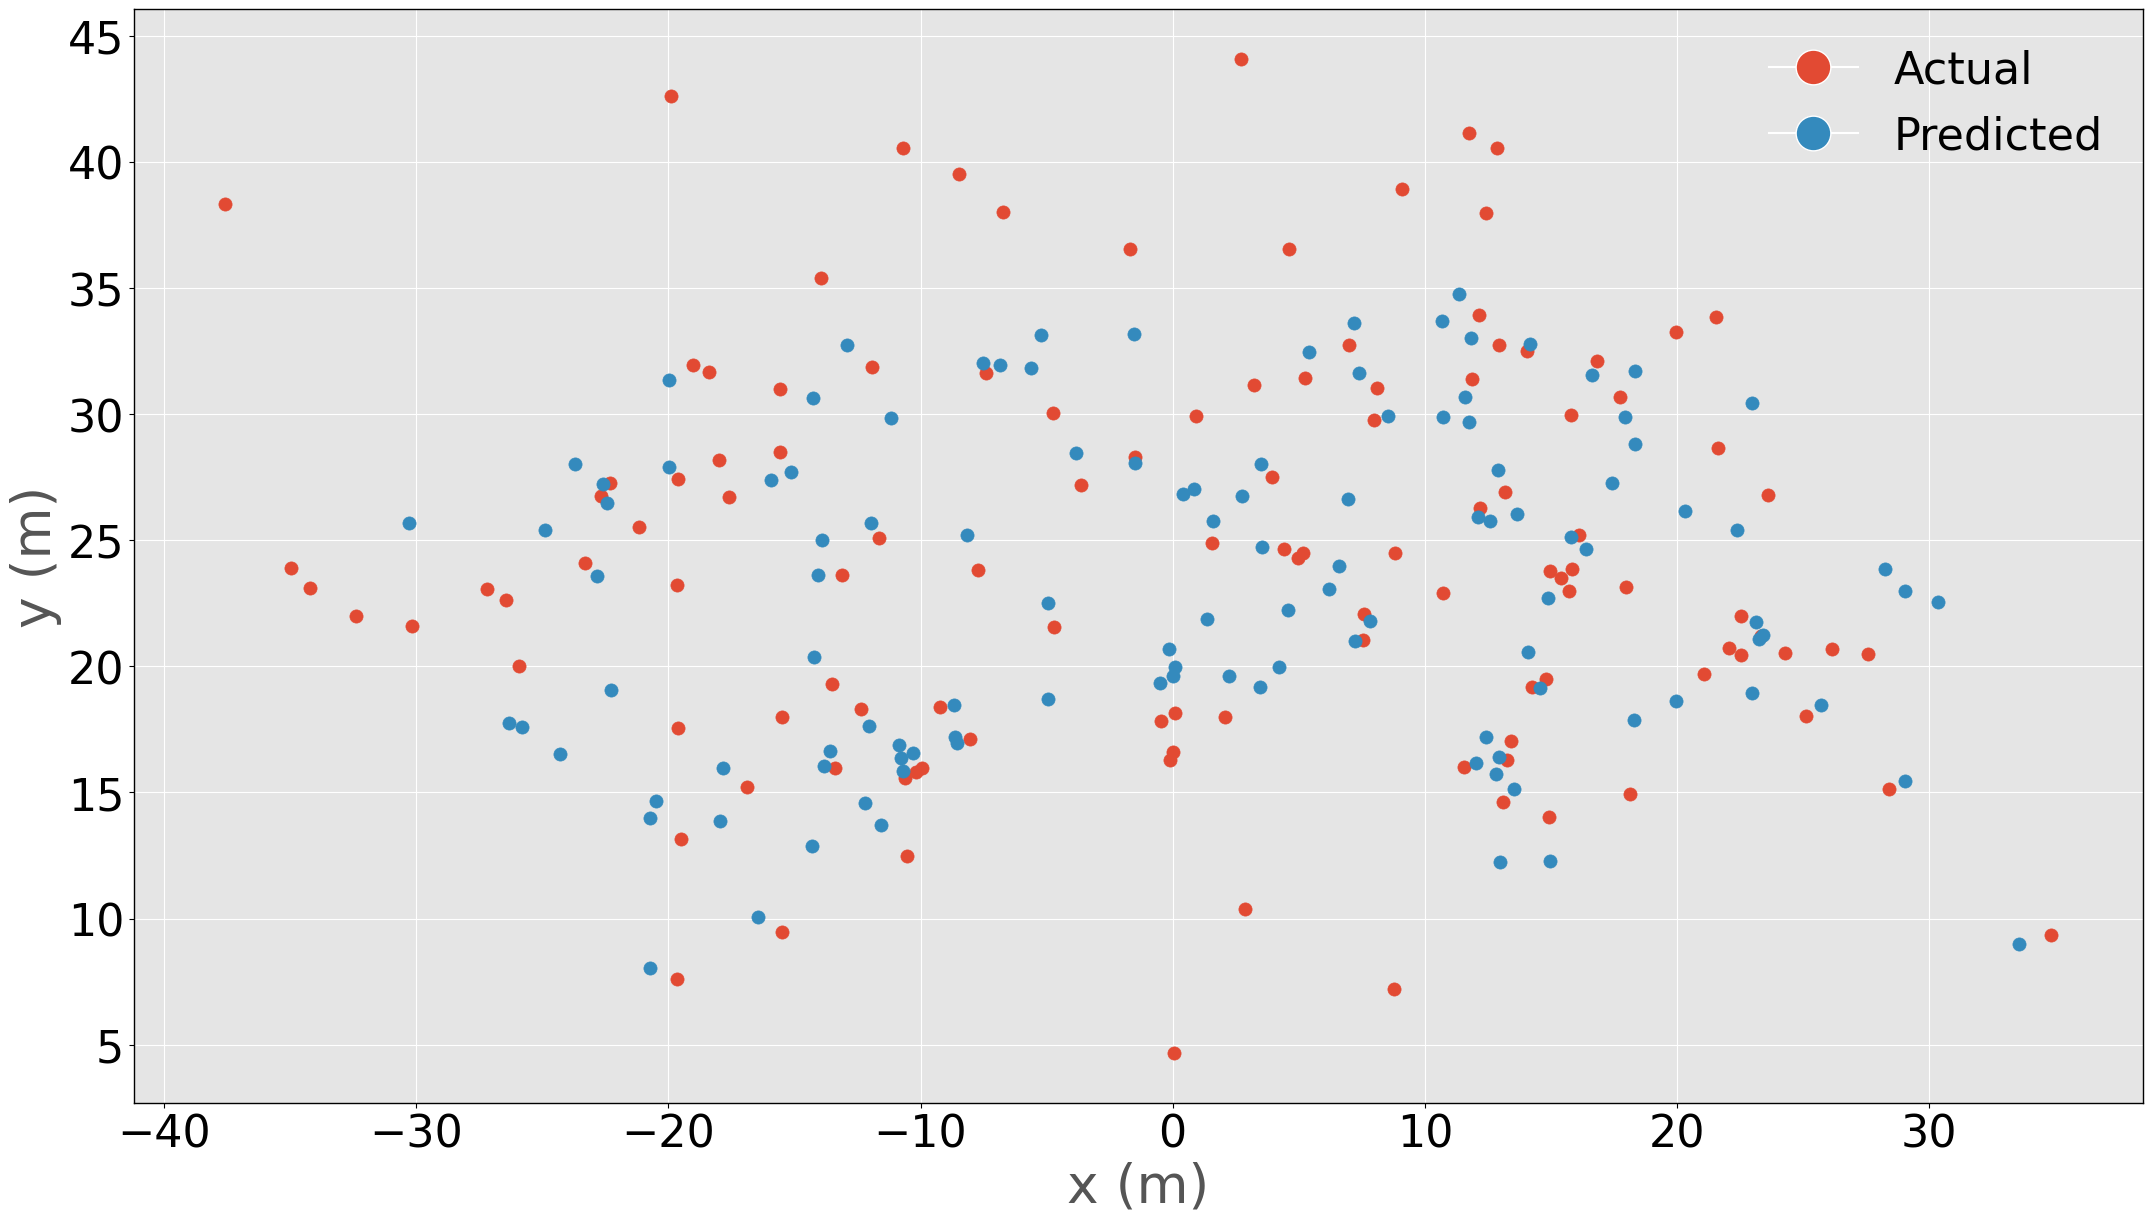

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

FIGSIZE          = (24, 13)
POINT_SIZE       = 90
POINT_ALPHA      = 1
ARROW_SUBSAMPLE  = 0
ARROW_ALPHA      = 0.75
ARROW_COLOR      = "black"

fig, ax = plt.subplots(figsize=FIGSIZE)

act = ax.scatter(sample.act_x_m,  sample.act_y_m,
                 s=POINT_SIZE, alpha=POINT_ALPHA, label="Actual")
pred = ax.scatter(sample.pred_x_m, sample.pred_y_m,
                  s=POINT_SIZE, alpha=POINT_ALPHA, label="Predicted")

idx = np.random.default_rng(1).choice(len(sample), size=min(ARROW_SUBSAMPLE, len(sample)), replace=False)
dx  = (sample.act_x_m - sample.pred_x_m).values[idx]
dy  = (sample.act_y_m - sample.pred_y_m).values[idx]

ax.quiver(sample.pred_x_m.values[idx], sample.pred_y_m.values[idx],
          dx, dy, angles='xy', scale_units='xy', scale=1,
          width=0.002, headwidth=4, headlength=6,
          color=ARROW_COLOR, alpha=ARROW_ALPHA, zorder=1)

ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")

legend_handles = [
    Line2D([0], [0], marker='o', color='w', label='Actual',
           markerfacecolor=act.get_facecolors()[0], markersize=25, alpha=1.0),
    Line2D([0], [0], marker='o', color='w', label='Predicted',
           markerfacecolor=pred.get_facecolors()[0], markersize=25, alpha=1.0),
]
ax.legend(handles=legend_handles, frameon=False)

plt.tight_layout()
plt.show()